# Compare the resolution limits of root-MUSIC and MVDR beamformer for a ULA

In [1]:
import numpy as np
import doatools.model as model
import doatools.estimation as estimation
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
wavelength = 1.0 # normalized
d0 = wavelength / 2

# Create a 10-element ULA.
ula = model.UniformLinearArray(10, d0)

# All sources share the same power.
# SNR = 0 dB
power_source = 1.0 # Normalized
power_noise = 1.0
source_signal = model.ComplexStochasticSignal(2, power_source)
noise_signal = model.ComplexStochasticSignal(ula.size, power_noise)
# 100 snapshots.
n_snapshots = 100
# Use root-MUSIC and MVDR beamformer
root_music = estimation.RootMUSIC1D(wavelength)
grid = estimation.FarField1DSearchGrid(start=-30.0, stop=30.0,
                                       size=1000, unit='deg')
mvdr = estimation.MVDRBeamformer(ula, wavelength, grid)

We consider two sources placed at $-\Delta\theta/2$ and $\Delta\theta/2$. We reduce $\Delta\theta$ from $10^\circ$ to $0.05^\circ$ and use Monte Carlo simulations to obtain the empirical resolution probabilities.

Given the estimates, $\hat{\theta}_1$, $\hat{\theta}_2$ ($\hat{\theta}_1 < \hat{\theta}_2$), we say the two sources are successfully resolved if $\hat{\theta}_1 \in (-\Delta\theta, 0)$ and $\hat{\theta}_2 \in (0, \Delta\theta)$. This condition is pretty strict. It requires that the estimated DOAs are reasonably close to the correct ones. On the other hand, in our implementation of DOA estimators, the resolved flag is set to `True` whenever the estimator can identify the correct number of sources even if the estimated locations are completely wrong.

In [3]:
def is_strictly_resolved(estimates, delta_theta):
    '''Helper function to check the resolution.'''
    if estimates.locations[0] >= 0 or estimates.locations[0] <= -delta_theta:
        return False
    if estimates.locations[1] <= 0 or estimates.locations[1] >= delta_theta:
        return False
    return True

delta_thetas = np.linspace(0.05, 10.0, 20)
# Repeat 500 times for each pair of sources.
n_repeats = 500
res_probs = np.zeros((delta_thetas.size, 2))
for i, delta_theta in enumerate(tqdm(delta_thetas)):
    n_resolved = np.array([0.0, 0.0])
    for r in range(n_repeats):
        sources = model.FarField1DSourcePlacement(
            [-delta_theta / 2, delta_theta / 2],
            unit='deg'
        )
        y, R = model.get_narrowband_snapshots(
            ula, sources, wavelength, source_signal, noise_signal, n_snapshots,
            return_covariance=True
        )
        res_mu, est_mu = root_music.estimate(R, 2, d0, unit='deg')
        res_mvdr, est_mvdr = mvdr.estimate(R, 2)
        if res_mu and is_strictly_resolved(est_mu, delta_theta):
            n_resolved[0] += 1
        if res_mvdr and is_strictly_resolved(est_mvdr, delta_theta):
            n_resolved[1] += 1
    res_probs[i, :] = n_resolved / n_repeats

100%|██████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.47s/it]


We plot the results below. We observe that the root-MUSIC algorithm provides much better resolution than the MVDR beamformer.

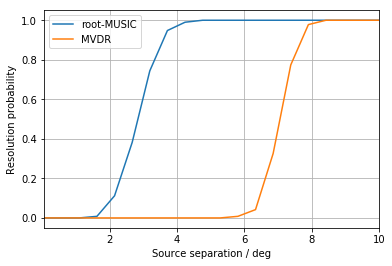

In [4]:
plt.figure()
plt.plot(delta_thetas, res_probs[:, 0], label='root-MUSIC')
plt.plot(delta_thetas, res_probs[:, 1], label='MVDR')
plt.grid(True)
plt.xlabel('Source separation / deg')
plt.ylabel('Resolution probability')
plt.margins(x=0)
plt.legend()
plt.show()